## Notebook for instantaneous causality with SCMs

This notebook provides code for using the CD-NOD algorithm to determine ONLY instantaneous causality among the variables.

In [1]:
import sys
import numpy as np
sys.path.insert(0, '../scripts')

from causallearn.search.ConstraintBased.CDNOD import cdnod
from causallearn.search.FCMBased.ANM.ANM import ANM


from dataset import EarthSystemsDataset
from multi_anm import M_ANM


In [2]:
data_var_names = ['global_temp', 'elec_fossil', 'elec_clean', 'co2', 'ch4', 'petroleum']
y_vals = ['temp_change']
lags = 15

earth_data = EarthSystemsDataset(data_var_names, y_vals=y_vals, val_frac=0.1, lags=lags, mode='ann')
earth_data.full_mode()
earth_data.data

temp_change  elec_fossil  elec_clean  co2_average  ch4_average  \
year month                                                                   
1983 Jul           0.18     4.325726    0.345359       342.14      1625.94   
     Aug           0.35     4.710642    0.338025       340.62      1628.06   
     Sep           0.37     4.546845    0.315758       340.53      1638.44   
     Oct           0.17     4.699021    0.320524       341.75      1644.79   
     Nov           0.30     4.574850    0.325785       342.83      1642.60   
...                 ...          ...         ...          ...          ...   
2023 May           0.94     7.244133    0.740660       420.56      1920.00   
     Jun           1.08     7.063367    0.691709       419.57      1915.94   
     Jul           1.19     7.253938    0.711895       417.85      1914.56   
     Aug           1.19     7.397303    0.711962       416.59      1919.15   
     Sep           1.48     7.202198    0.666253       416.99      1927.35   

               petroleum  
year month                
1983 Jul     8636.032000  
     Aug     8679.129000  
     Sep     8784.333000  
     Oct     8770.645000  
     Nov     8770.367000  
...                  ...  
2023 May    80846.269332  
     Jun    81759.208221  
     Jul    81006.724819  
     Aug    80639.447798  
     Sep    81554.209233  

[483 rows x 6 columns]

## Use CD-NOD to get a SCM
CD-NOD is an extension of the PC algorithm that is able to handle nonstationary data by providing a time index. This saves us from the tediousness of differencing our data.

In [3]:
d = earth_data.data.to_numpy()
cg = cdnod(d, np.arange(earth_data.data.shape[0]).reshape(-1,1) / 10.0, indep_test='kci')

  0%|          | 0/7 [00:00<?, ?it/s]

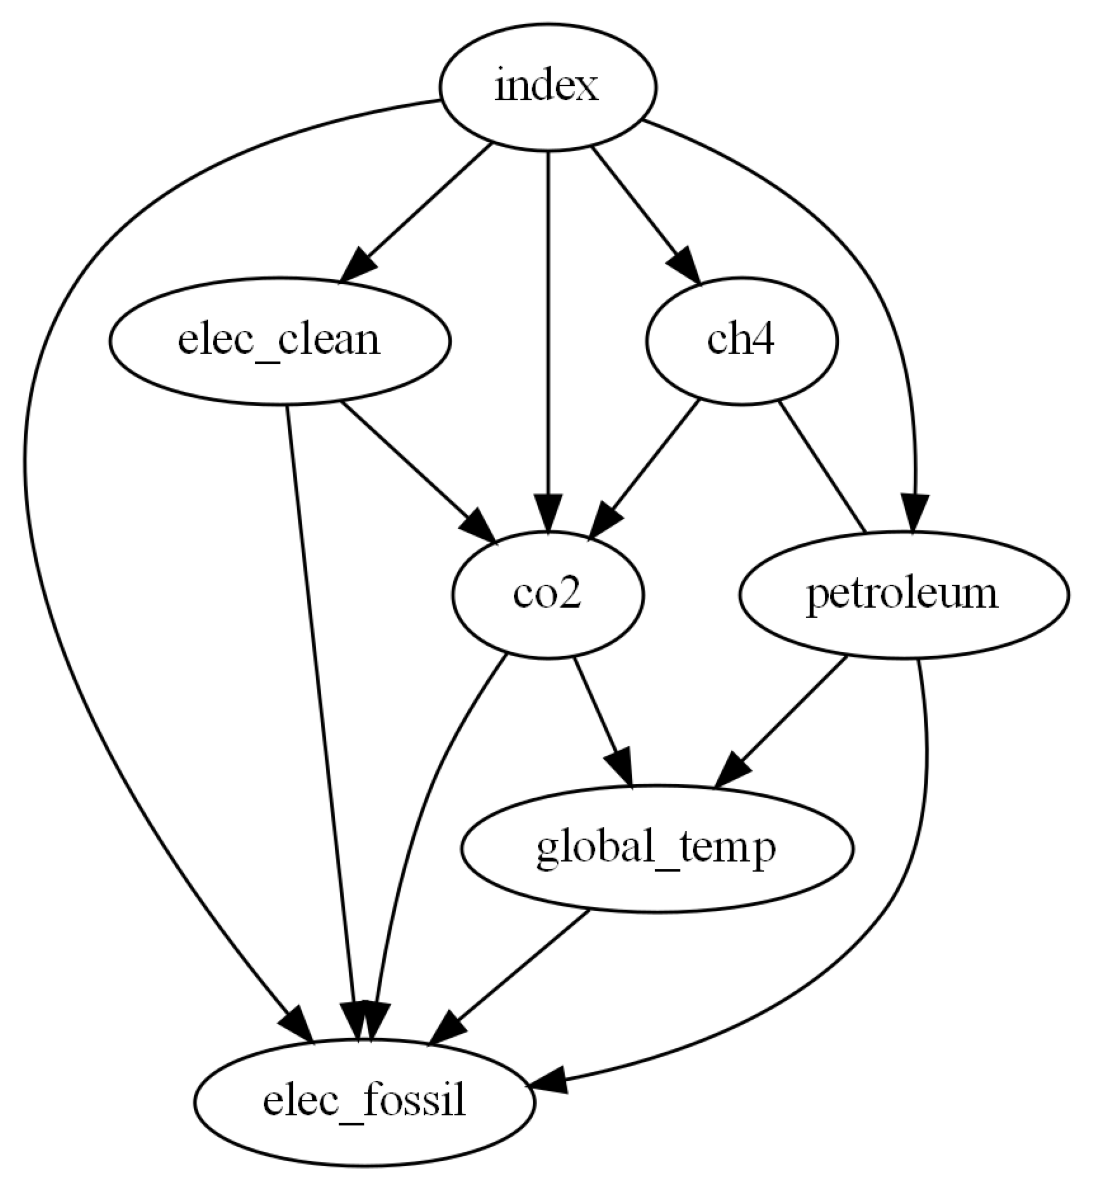

In [ ]:
cg.draw_pydot_graph(labels=['Global Temperature',
                           'Electricity (Fossil Fuels)',
                           'Electricity (Clean)',
                           'Carbon Dioxide',
                           'Methane',
                           'Petroleum Production']+['Time'])

In [ ]:
cg.G.graph

array([[ 0, -1,  0,  1,  0,  1,  0],
       [ 1,  0,  1,  1,  0,  1,  1],
       [ 0, -1,  0, -1,  0,  0,  1],
       [-1, -1,  1,  0,  1,  0,  1],
       [ 0,  0,  0, -1,  0, -1,  1],
       [-1, -1,  0,  0, -1,  0,  1],
       [ 0, -1, -1, -1, -1, -1,  0]])

In the map above, an arrow points from variable *x* to variable *y* if it has been determined that *x* causes *y* in the instantaneous case. "Instantaneous" means causality among the 6 variables during the same time step.

We can see that many of the results don't make sense. The SCM finds that *global_temp* (global temperature) and *co2* are causes of *elec_fossil* (fossil fuels electricity generation), when in reality it should be the other way around. However, some relations do make sense, such as *co2* affecting *global_temp*.

## Discover directional relationships

CD-NOD was not able to determine the causal direction between *ch4* and *petroleum*. We can use Multivariate ANM to do this. We also provide univariate ANM as a baseline, but there is a confounding variable (*Time*).

In [ ]:
anm = ANM()
manm = M_ANM()

In [ ]:
X = earth_data.data['ch4_average']
y = earth_data.data['petroleum']
conf = range(len(earth_data.data))

In [ ]:
p_value_forward, p_value_backward = anm.cause_or_effect(X.array.reshape(-1, 1),y.array.reshape(-1, 1))
print(p_value_forward, p_value_backward)

0.0 1.2856382625159313e-13


In [ ]:
time = range(len(earth_data.data))
temp_data =earth_data.data
temp_data['Time'] = time
X = earth_data.data[['ch4_average']]
y = earth_data.data[['petroleum']]
conf = earth_data.data[['Time']]

In [ ]:
p_value_forward, p_value_backward = manm.cause_or_effect(X,y, conf)
print(p_value_forward, p_value_backward)

0.0 0.0


We can see that our results don't really make sense above- Multivariate ANM did not find any correlation between *ch4* and *petroleum*, even though CD-NOD did (the p-values for both cases *ch4* --> *petroleum* and *petroleum* --> *ch4* are 0).

This is due to the fact that we are not considering time-lagged causality. See *time_lagged* and *combined* notebooks/scripts for the main analysis.